In [62]:
from time import time
from os import listdir
from os.path import isdir, isfile
from scipy.optimize import curve_fit
import scipy.stats as stats
from scipy.stats import binom, chisquare
#from scipy.stats import ks_2samp
from math import factorial
import glob
import argparse
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

In [63]:
plt.rcParams.update({'font.size': 15})
dirlist, mt_dirlist = [], []
for d in listdir(f'results'):
    if isdir(f'results/{d}') and (d != '.ipynb_checkpoints') and ('SM' in d) and (not 'PFAM' in d):
        if not 'mt' in d:
            dirlist.append(d)
        else:
            mt_dirlist.append(d)

In [64]:
dirlist

['SM_1PGB_T0.0116_g0.0',
 'SM_1PGB_T0.0016_g0.0',
 'SM_1PGB_T0.0021_g0.0',
 'SM_1PGB_T0.0064_g0.0',
 'SM_1PGB_T0.0032_g0.0',
 'SM_1PGB_T0.0080_g0.0',
 'SM_1PGB_T0.0171_g0.0',
 'SM_1PGB_T0.0136_g0.0',
 'SM_1PGB_T0.0048_g0.0',
 'SM_1PGB_T0.0024_g0.0',
 'SM_1PGB_T0.0011_g0.0',
 'SM_1PGB_T0.0096_g0.0',
 'SM_1PGB_T0.0008_g0.0']

In [65]:
mt_dirlist

['SM_1PGB-mt3_T0.0032_g0.0',
 'SM_1PGB-mt4_T0.0032_g0.0',
 'SM_1PGB-mt2_T0.0032_g0.0',
 'SM_1PGB-mt1_T0.0032_g0.0',
 'SM_1PGB-mt5_T0.0032_g0.0']

In [66]:
## Order dirlist
def order_dirlist(dirlist):
    T_dirlist, gamma_dirlist = [], []
    Tlist, gammalist = [], []
    for d in dirlist:
        splitted_d = d.split('_')
        T, gamma = float(splitted_d[-2][1:]), float(splitted_d[-1][1:])
        if gamma == 0:
            T_dirlist.append(d)
            Tlist.append(T)
        else:
            gamma_dirlist.append(d)
            gammalist.append(gamma)
        
    ord_Tlist = np.sort(Tlist)[::-1]
    T_dirlist = [T_dirlist[Tlist.index(T)] for T in ord_Tlist]

    ord_gammalist = np.sort(gammalist)[::-1]
    gamma_dirlist = [gamma_dirlist[gammalist.index(T)] for T in ord_gammalist]
    return T_dirlist, gamma_dirlist


## Load simulation data
def load_data(d, return_eq = True):
    datafiles = np.array([f for f in listdir(d) if isfile(f'{d}/{f}') and 'data' in f])

    file = datafiles[[not 'eq' in datafile for datafile in datafiles]][0]
    with open(f'{d}/{file}', 'r') as f:
        lines = f.readlines()
    splitted_lines = [line.split('\t') for line in lines]
    data = np.array(splitted_lines).astype(float)

    if return_eq:
        eq_file = datafiles[['eq' in datafile for datafile in datafiles]][0]
        with open(f'{d}/{eq_file}', 'r') as f:
            lines = f.readlines()
        splitted_lines = [line.split('\t') for line in lines]
        eq_data = np.array(splitted_lines).astype(float)

        return eq_data, data

    else:
        return data


## Load simulation mutations
def load_muts(d, return_eq = True, return_pars = True):
    mutsfiles = np.array([f for f in listdir(d) if isfile(f'{d}/{f}') and 'mutants' in f])

    file = mutsfiles[[not 'eq' in mutsfile for mutsfile in mutsfiles]][0]
    with open(f'{d}/{file}', 'r') as f:
        lines = f.readlines()
    splitted_lines = [line.split('\t') for line in lines]
    muts = np.array(splitted_lines).astype(str)
    for idx in range(len(muts)):
        muts[idx, 1] = muts[idx, 1][:-1]

    if return_eq:
        eq_file = mutsfiles[['eq' in mutsfile for mutsfile in mutsfiles]][0]
        with open(f'{d}/{eq_file}', 'r') as f:
            lines = f.readlines()
        splitted_lines = [line.split('\t') for line in lines]
        eq_muts = np.array(splitted_lines).astype(str)
        for idx in range(len(eq_muts)):
            eq_muts[idx, 1] = eq_muts[idx, 1][:-1]

    if return_pars:
        splitted_d = d.split('/')
        seed = int(splitted_d[-1][1:])
        
        resplitted_d = splitted_d[-2].split('_')
        T = float(resplitted_d[-2][1:])
        gamma = float(resplitted_d[-1][1:])

    if return_eq and return_pars:
        return eq_muts, muts, (T, gamma, seed)
    elif return_eq:
        return eq_muts, muts
    elif return_pars:
        return muts, (T, gamma, seed)
    else:
        return muts

In [67]:
T_dirlist, gamma_dirlist = order_dirlist(dirlist)
T_mt_dirlist, gamma_mt_dirlist = order_dirlist(mt_dirlist)

---
Ordered wild-type directories

In [68]:
T_dirlist

['SM_1PGB_T0.0171_g0.0',
 'SM_1PGB_T0.0136_g0.0',
 'SM_1PGB_T0.0116_g0.0',
 'SM_1PGB_T0.0096_g0.0',
 'SM_1PGB_T0.0080_g0.0',
 'SM_1PGB_T0.0064_g0.0',
 'SM_1PGB_T0.0048_g0.0',
 'SM_1PGB_T0.0032_g0.0',
 'SM_1PGB_T0.0024_g0.0',
 'SM_1PGB_T0.0021_g0.0',
 'SM_1PGB_T0.0016_g0.0',
 'SM_1PGB_T0.0011_g0.0',
 'SM_1PGB_T0.0008_g0.0']

In [69]:
gamma_dirlist

[]

---
Ordered mutants directories

In [70]:
T_mt_dirlist

['SM_1PGB-mt3_T0.0032_g0.0',
 'SM_1PGB-mt3_T0.0032_g0.0',
 'SM_1PGB-mt3_T0.0032_g0.0',
 'SM_1PGB-mt3_T0.0032_g0.0',
 'SM_1PGB-mt3_T0.0032_g0.0']

In [71]:
gamma_mt_dirlist

[]

---
# SM simulations, gamma = 0

### Single T plots

# dirlist = T_dirlist

### Processed data and curve prediction

In [12]:
processed_data = pd.read_csv('results/processed_data.csv')
processed_data = processed_data.drop(columns = ['Unnamed: 0'])

In [13]:
processed_data

,energy,energy error,energy chi,energy chi error,PAM1 distance,PAM1 distance error,PAM1 distance chi,PAM1 distance chi error,Hamm distance,Hamm distance error,Hamm distance chi,Hamm distance chi error,block_size,used_mutations,discarded_mutations,T,gamma,length
0,0.003363,0.000489,13.970689,3.305094,0.577167,0.009734,0.0,0.0,0.629323,0.010598,0.0,0.0,20000.0,480000.0,240000.0,0.0008,0.0,56.0
1,0.005116,0.001008,10.270503,4.075656,0.591205,0.005458,0.0,0.0,0.660323,0.005825,0.0,0.0,20000.0,40000.0,80000.0,0.0011,0.0,56.0
2,0.019899,0.000929,23.372814,5.556620,0.635148,0.006044,0.0,0.0,0.696990,0.006654,0.0,0.0,20000.0,480000.0,120000.0,0.0016,0.0,56.0
3,0.035429,0.001581,26.670939,7.357645,0.649491,0.007276,0.0,0.0,0.715746,0.007522,0.0,0.0,20000.0,360000.0,80000.0,0.0021,0.0,56.0
4,0.043525,0.001857,35.136093,7.611714,0.670063,0.006478,0.0,0.0,0.736798,0.007032,0.0,0.0,20000.0,460000.0,200000.0,0.0024,0.0,56.0
5,0.073677,0.001235,25.422655,6.037019,0.723855,0.003768,0.0,0.0,0.789100,0.003614,0.0,0.0,20000.0,1160000.0,180000.0,0.0032,0.0,56.0
6,0.103705,0.004394,23.622445,8.959775,0.754383,0.007647,0.0,0.0,0.821105,0.007956,0.0,0.0,20000.0,240000.0,30000.0,0.0048,0.0,56.0
7,0.155951,0.003700,16.277276,7.500511,0.801260,0.005472,0.0,0.0,0.864647,0.006080,0.0,0.0,20000.0,240000.0,30000.0,0.0064,0.0,56.0
8,0.174711,0.004997,16.304291,7.412512,0.808227,0.005390,0.0,0.0,0.872306,0.005223,0.0,0.0,20000.0,280000.0,20000.0,0.0080,0.0,56.0
9,0.199099,0.005043,15.667437,6.631834,0.821083,0.004676,0.0,0.0,0.884091,0.004739,0.0,0.0,20000.0,220000.0,20000.0,0.0096,0.0,56.0


In [14]:
def get_step_mean(data, step, return_length = True):
    nstep = int(len(data) / step)
    step_mean = np.array([data[0]] + [data[:(step * (istep + 1))].mean() for istep in range(nstep)])
    if return_length:
        step_length = np.array([data[0]] + [step * (istep + 1) for istep in range(nstep)])
        return step_mean, step_length
    else:
        return step_mean

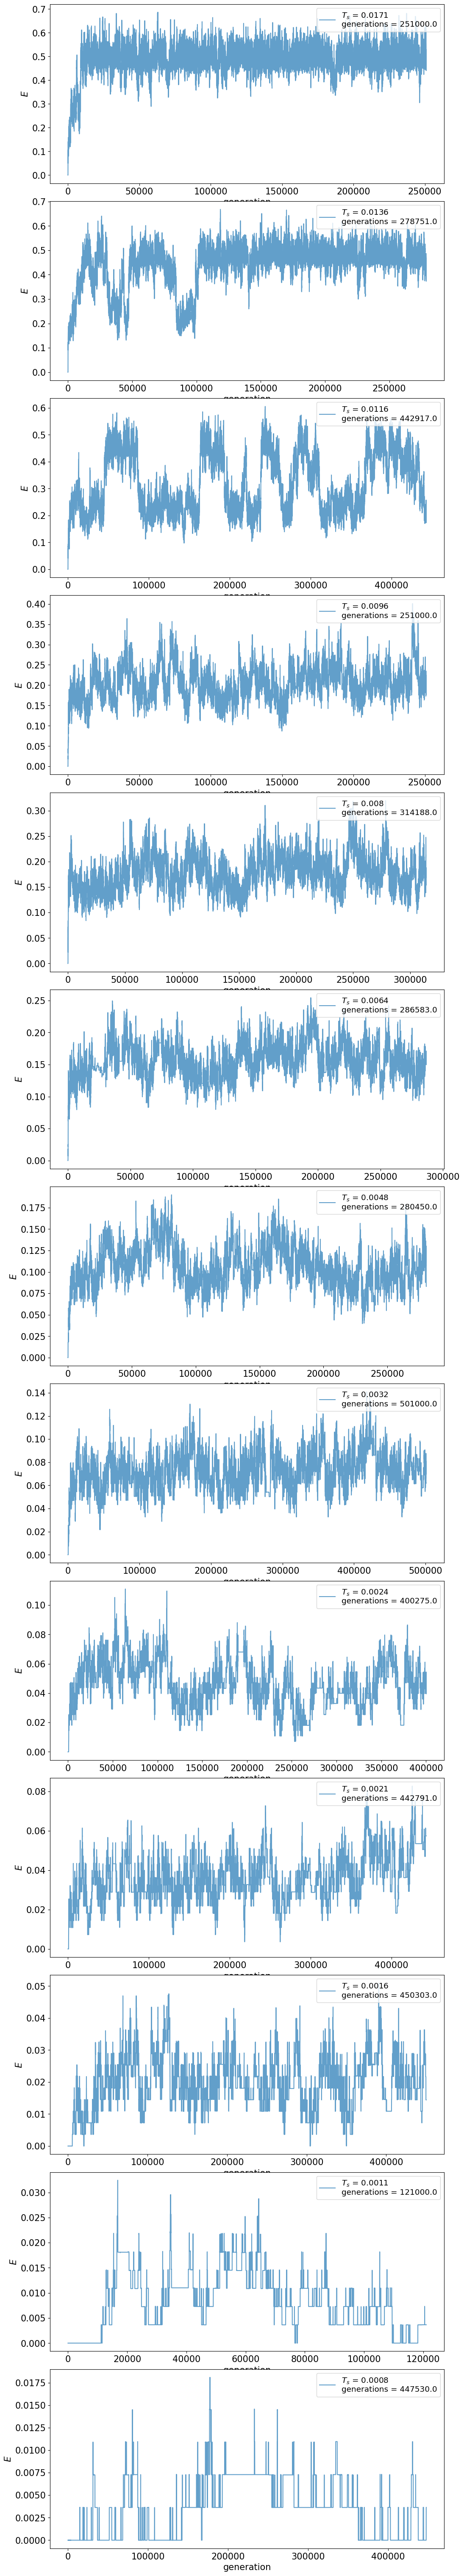

In [48]:
threshold = 300_000
num_plots = len(T_dirlist)

shown_Ts, shown_seeds, num_seeds = [], [], []
fig, axs = plt.subplots(figsize = (12, 6*num_plots), nrows = num_plots)
for d, ax in zip(T_dirlist, axs):
    seed_ds = [subd for subd in listdir(f'results/{d}') if isdir(f'results/{d}/{subd}')]
    seeds = 1
    seed_d = 's0'
    
    if len(seed_ds) > 1:
        tot_generations = []
        for seed_d in seed_ds:
            actual_d = f'results/{d}/{seed_d}'
            eq_data, data = load_data(actual_d)
            eq_generations, generations = eq_data[:, 0], data[:, 0]
            tot_generations.append(eq_generations.max() + generations.max())
        seeds = len(seed_ds)
        seed_d = seed_ds[np.argmax(tot_generations)]

    actual_d = f'results/{d}/{seed_d}'
    eq_data, data = load_data(actual_d)
    eq_generations, generations = eq_data[:, 0], data[:, 0]
    T = data[0, -3]
        
    tot_generations = np.append(eq_generations, generations[1:])
    tot_data = np.append(eq_data, data[1:]).reshape((len(tot_generations), 9))

    if tot_generations[-1] >= threshold: 
        shown_Ts.append(T)
        shown_seeds.append(int(seed_d[1:]))
        num_seeds.append(seeds)
        
    ax.plot(tot_generations, tot_data[:, 1], alpha = 0.7, label = r'$T_s$ = ' + f'{T}\ngenerations = {tot_generations[-1]}')
    ax.set_ylabel(r'$E$')
    ax.set_xlabel('generation')
    ax.legend(loc = 'upper right', fontsize = 13.3)
        
plt.subplots_adjust(hspace = 0.1)
#plt.savefig(f'plots/supp_mat/observables_g0.0.png', bbox_inches='tight');

In [50]:
shown_Ts

[0.0116, 0.008, 0.0032, 0.0024, 0.0021, 0.0016, 0.0008]

In [51]:
shown_seeds

[0, 0, 1, 0, 0, 0, 0]

In [52]:
num_seeds

[1, 1, 3, 2, 1, 2, 2]

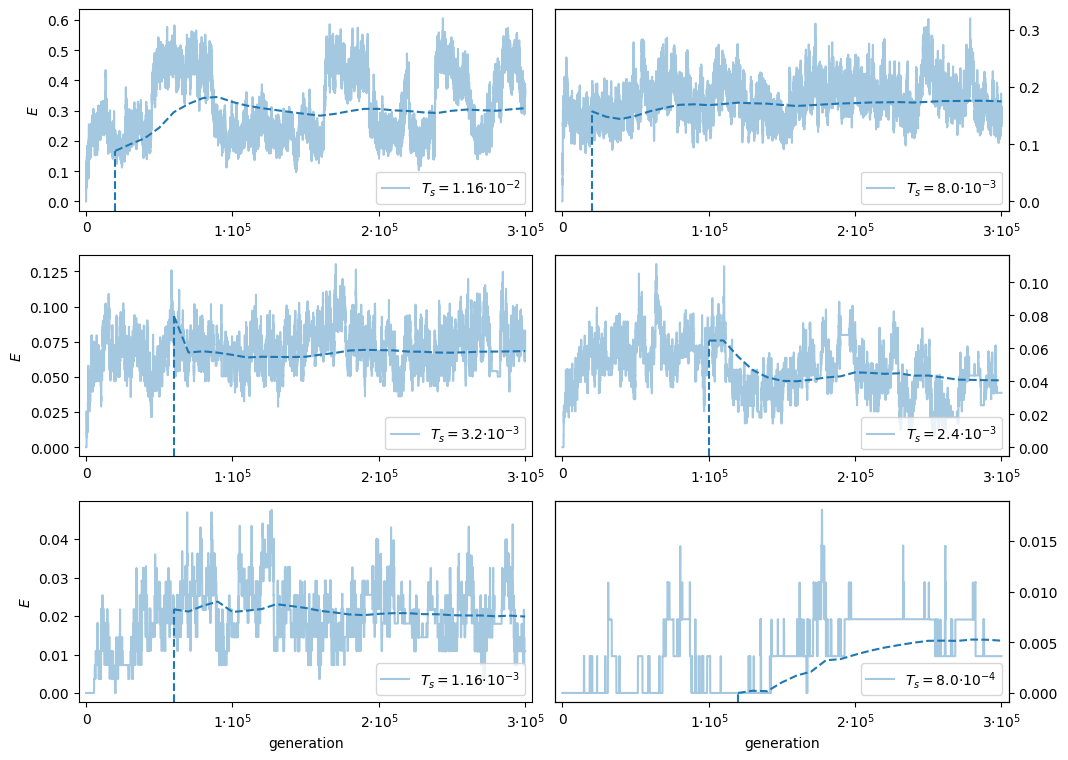

In [36]:
plt.rcParams.update({'font.size': 10})

Ts = [0.0116, 0.008, 0.0032, 0.0024, 0.0016, 0.0008]
T_labels = [r'1.16$\cdot$10$^{-2}$', r'8.0$\cdot$10$^{-3}$', r'3.2$\cdot$10$^{-3}$', 
            r'2.4$\cdot$10$^{-3}$', r'1.16$\cdot$10$^{-3}$', r'8.0$\cdot$10$^{-4}$']
seeds = [0, 0, 1, 0, 0, 0]
sims = [1, 1, 3, 2, 2, 2]

step = 10_000
threshold = 300_000

xticks = [0, 100_000, 200_000, 300_000]
xticklabels = [r'0', r'1$\cdot$10$^{5}$', r'2$\cdot$10$^{5}$', r'3$\cdot$10$^{5}$']

fig, axs = plt.subplots(figsize = (12, 9), nrows = 3, ncols = 2)
axs = axs.reshape(-1)

iax = 0
for T, T_label, seed, num in zip(Ts, T_labels, seeds, sims):
    ax = axs[iax]
    
    discarded_mutations = int(processed_data.loc[processed_data['T'] == T, 'discarded_mutations'].iloc[0] / num)
    actual_d = [f'results/{d}/s{seed}' for d in listdir('results') 
                if isdir(f'results/{d}') and (str(T) in d) and ('SM' in d) and (not 'mt' in d) and (not 'PFAM' in d)]
    assert len(actual_d) == 1, f'Too many directories with T = {T}'
    actual_d = actual_d[0]

    eq_data, data = load_data(actual_d)
    eq_generations, generations = eq_data[:, 0], data[:, 0]
    length = data[0, -1]
        
    tot_generations = np.append(eq_generations, generations[1:])[:threshold]
    tot_data = np.append(eq_data, data[1:], axis = 0)[:threshold]

    if iax % 2 == 1: 
        new_ax = ax.twinx()
        ax.tick_params(left=False, labelleft=False)
        ax = new_ax
    step_mean, step_length = get_step_mean(tot_data[discarded_mutations:, 1], step = step, return_length = True)
    ax.plot(tot_generations, tot_data[:, 1], alpha = 0.4, label = r'$T_s = $' + T_label)
    color = ax.get_lines()[-1].get_color()
    ax.plot(discarded_mutations + step_length, step_mean, alpha = 1., color = color, linestyle = '--')

    ymin, yspan = ax.get_ylim()[0], np.diff(ax.get_ylim())[0]
    ax.axvline(discarded_mutations, ymax = (step_mean[0] - ymin)/yspan, color = color, linestyle = '--')

    ax.set_xlim([-5000, 305000])
    #ax.ticklabel_format(axis = 'x', style = 'sci', scilimits = (5, 5))
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.legend(loc = 'lower right')
    if iax % 2 == 0: ax.set_ylabel(r'$E$')
    if iax > 3: axs[iax].set_xlabel('generation')
    iax += 1
        
plt.subplots_adjust(wspace = 0.05, hspace = 0.22)
plt.savefig(f'plots/supp_mat/sample_energies.png', bbox_inches='tight');

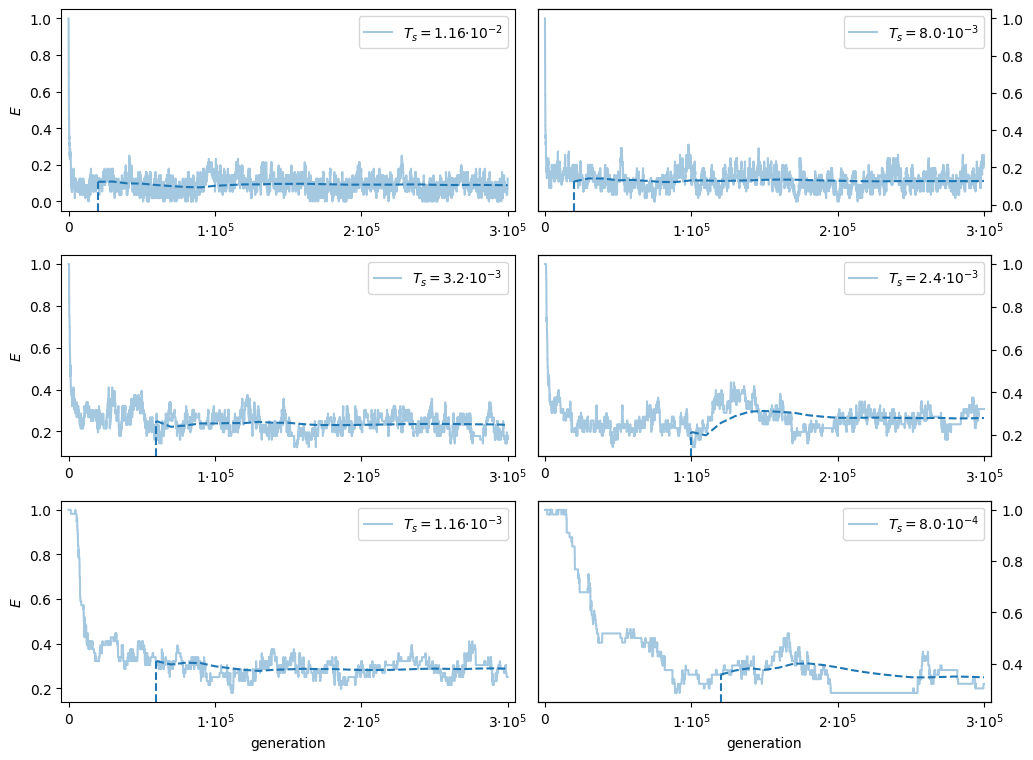

In [37]:
plt.rcParams.update({'font.size': 10})

Ts = [0.0116, 0.008, 0.0032, 0.0024, 0.0016, 0.0008]
T_labels = [r'1.16$\cdot$10$^{-2}$', r'8.0$\cdot$10$^{-3}$', r'3.2$\cdot$10$^{-3}$', 
            r'2.4$\cdot$10$^{-3}$', r'1.16$\cdot$10$^{-3}$', r'8.0$\cdot$10$^{-4}$']
seeds = [0, 0, 1, 0, 0, 0]
sims = [1, 1, 3, 2, 2, 2]

step = 10_000
threshold = 300_000

xticks = [0, 100_000, 200_000, 300_000]
xticklabels = [r'0', r'1$\cdot$10$^{5}$', r'2$\cdot$10$^{5}$', r'3$\cdot$10$^{5}$']

fig, axs = plt.subplots(figsize = (12, 9), nrows = 3, ncols = 2)
axs = axs.reshape(-1)

iax = 0
for T, T_label, seed, num in zip(Ts, T_labels, seeds, sims):
    ax = axs[iax]
    
    discarded_mutations = int(processed_data.loc[processed_data['T'] == T, 'discarded_mutations'].iloc[0] / num)
    actual_d = [f'results/{d}/s{seed}' for d in listdir('results') 
                if isdir(f'results/{d}') and (str(T) in d) and ('SM' in d) and (not 'mt' in d) and (not 'PFAM' in d)]
    assert len(actual_d) == 1, f'Too many directories with T = {T}'
    actual_d = actual_d[0]

    eq_data, data = load_data(actual_d)
    eq_generations, generations = eq_data[:, 0], data[:, 0]
    length = data[0, -1]
        
    tot_generations = np.append(eq_generations, generations[1:])[:threshold]
    tot_data = np.append(eq_data, data[1:], axis = 0)[:threshold]

    if iax % 2 == 1: 
        new_ax = ax.twinx()
        ax.tick_params(left=False, labelleft=False)
        ax = new_ax
    step_mean, step_length = get_step_mean(1. - tot_data[discarded_mutations:, 4]/length, step = step, return_length = True)
    ax.plot(tot_generations, 1. - tot_data[:, 4]/length, alpha = 0.4, label = r'$T_s = $' + T_label)
    color = ax.get_lines()[-1].get_color()
    ax.plot(discarded_mutations + step_length, step_mean, alpha = 1., color = color, linestyle = '--')

    ymin, yspan = ax.get_ylim()[0], np.diff(ax.get_ylim())[0]
    ax.axvline(discarded_mutations, ymax = (step_mean[0] - ymin)/yspan, color = color, linestyle = '--')

    ax.set_xlim([-5000, 305000])
    #ax.ticklabel_format(axis = 'x', style = 'sci', scilimits = (5, 5))
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.legend(loc = 'upper right')
    if iax % 2 == 0: ax.set_ylabel(r'$E$')
    if iax > 3: axs[iax].set_xlabel('generation')
    iax += 1
        
plt.subplots_adjust(wspace = 0.05, hspace = 0.22)
plt.savefig(f'plots/supp_mat/sample_qs.png', bbox_inches='tight');

#### Energy + Cv + plddt curve

In [17]:
with open('process/reweighting/reweighted_energies.dat', 'r') as f:
    lines = f.readlines()
lines = lines[1:]

pred_T = np.array([float(line.split('\t')[0]) for line in lines])
pred_energies = np.array([float(line.split('\t')[2]) for line in lines])
pred_shs = np.array([float(line.split('\t')[4]) for line in lines])

In [18]:
with open('process/plddt_profile/rescaled_plddt_profile.txt', 'r') as f:
    lines = f.readlines()
lines = np.array([line.split('\t') for line in lines], dtype = float)

Ts = lines[:, 0]
plddt_mean = lines[:, 1]
plddt_err = lines[:, 2]

/tmp/ipykernel_5836/242305493.py:18: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  big_ax.errorbar(masked_data['T'], energy, yerr = error,
/tmp/ipykernel_5836/242305493.py:41: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax.errorbar(Ts, plddt_mean, yerr = plddt_err, fmt = '.', marker = 'o', color = color, capsize=5)


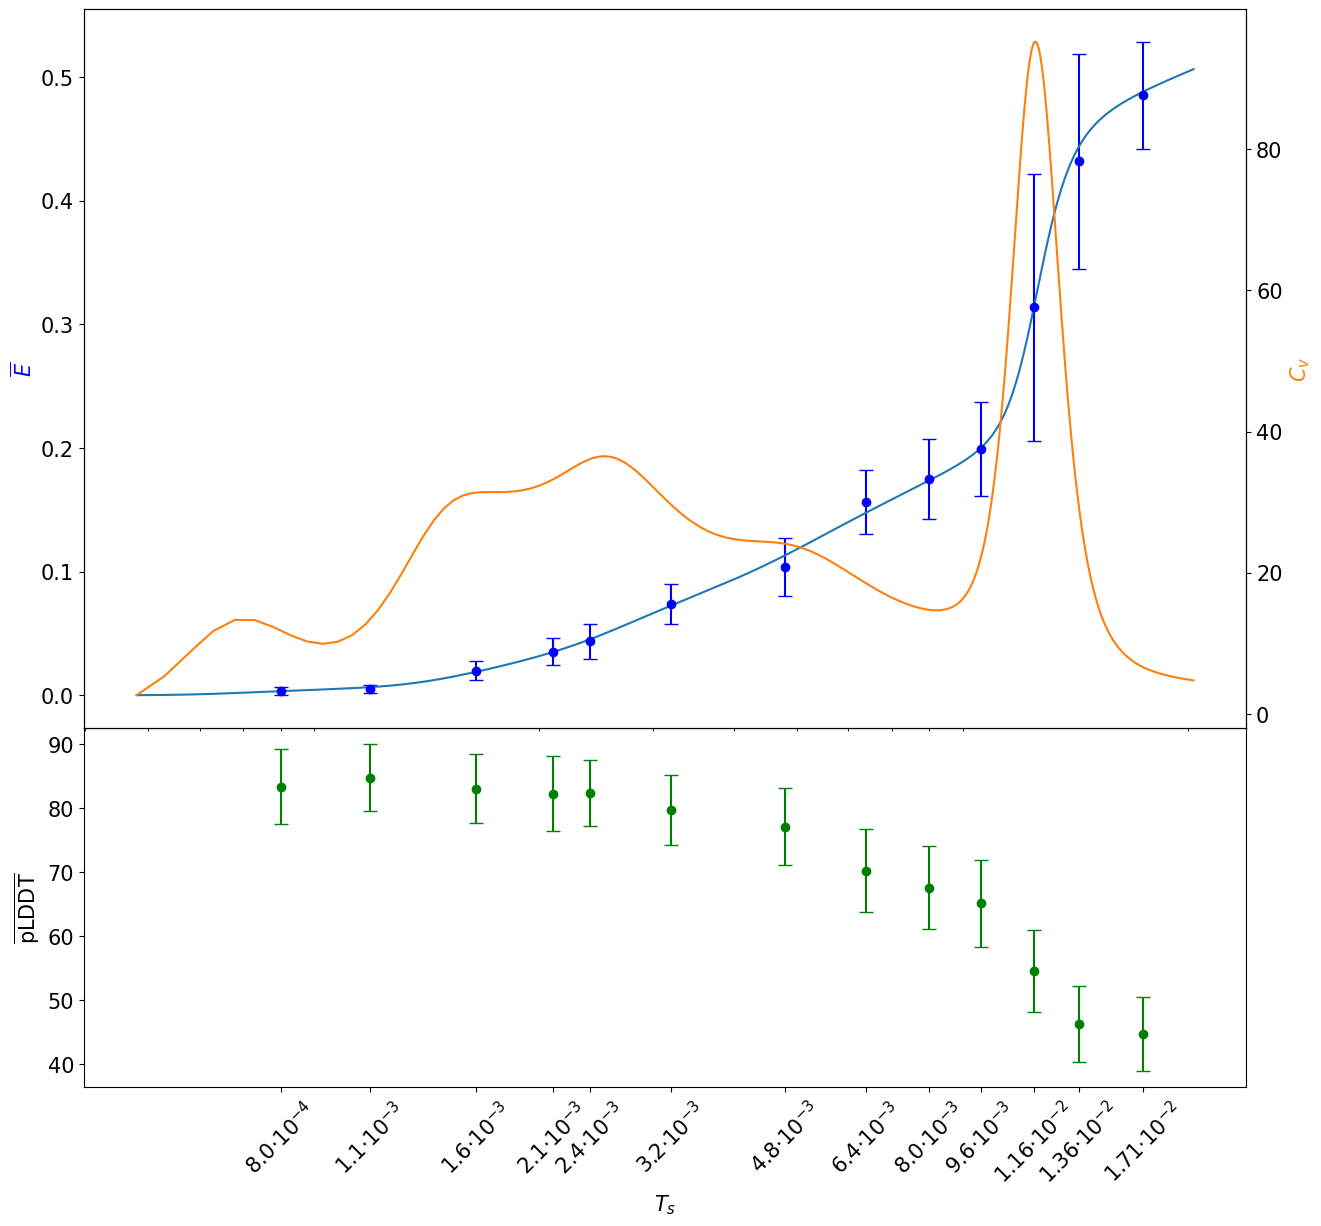

In [22]:
labels = [r'8.0$\cdot$10$^{-4}$', r'1.1$\cdot$10$^{-3}$', r'1.6$\cdot$10$^{-3}$', r'2.1$\cdot$10$^{-3}$', r'2.4$\cdot$10$^{-3}$', 
          r'3.2$\cdot$10$^{-3}$', r'4.8$\cdot$10$^{-3}$', r'6.4$\cdot$10$^{-3}$', r'8.0$\cdot$10$^{-3}$', r'9.6$\cdot$10$^{-3}$', 
          r'1.16$\cdot$10$^{-2}$', r'1.36$\cdot$10$^{-2}$', r'1.71$\cdot$10$^{-2}$']

plt.rcParams.update({'font.size': 15})
fig, axs = plt.subplots(figsize = (15, 14), ncols = 1, nrows = 3, sharex = True)

gs = axs[0].get_gridspec()
for ax in axs[:-1]:
    ax.remove()
big_ax = fig.add_subplot(gs[:-1])
ax = axs[-1]

# Effective energy
color = '#1f77b4' # blue
masked_data = processed_data.loc[processed_data.loc[:, 'gamma'] == 0., :]
energy, error = masked_data['energy'], np.sqrt(masked_data['energy chi'] * masked_data['T']**2)
big_ax.errorbar(masked_data['T'], energy, yerr = error,
            fmt = '.', marker = 'o', color = 'blue', capsize=5)
big_ax.plot(pred_T, pred_energies, color = color)

big_ax.set_xscale('log')
big_ax.set_ylabel(r'$\overline{E}$', color = 'blue')


# Specific heat
color = '#ff7f0e' # orange
big_ax = big_ax.twinx()
big_ax.plot(pred_T, pred_shs, color = color)

big_ax.set_xscale('log')
big_ax.set_ylabel(r'$C_{v}$', color = color)

xlim = big_ax.get_xlim()
big_ax.set_xticks([])
big_ax.tick_params(axis='x', which='minor', bottom=False)


# Plddt
color = 'green'
ax.errorbar(Ts, plddt_mean, yerr = plddt_err, fmt = '.', marker = 'o', color = color, capsize=5)
    
ax.set_xlim(xlim)
ax.set_xscale('log')
ax.set_xlabel(r'$T_s$')
ax.set_ylabel(r'$\overline{\mathrm{pLDDT}}$')
ax.set_xticks(masked_data['T'])
ax.set_xticklabels(labels, rotation = 45)
ax.tick_params(axis='x', which='minor', bottom=False)

plt.subplots_adjust(hspace = 0.)
plt.savefig(f'plots/energy_prediction.png', bbox_inches='tight');

#### Distance curve

In [25]:
T_list = []
for d in dirlist:
    T = float(d.split('_')[2][1:])
    T_list.append(T)
T_list = np.array(T_list)

/tmp/ipykernel_5836/3597173294.py:16: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax.errorbar(masked_data['T'], 1. - masked_data[f'{dtype} distance'], yerr = masked_data[f'{dtype} distance error'],


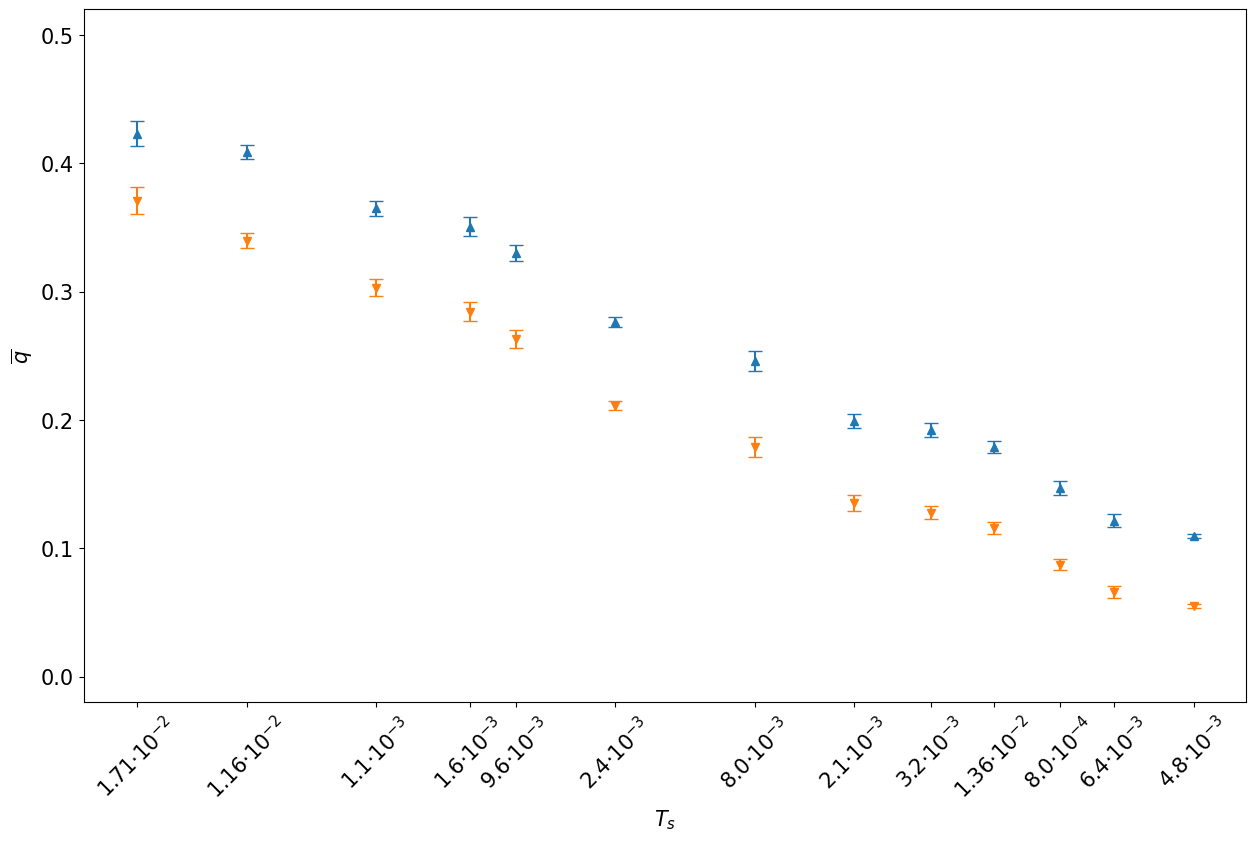

In [26]:
labels = [r'8.0$\cdot$10$^{-4}$', r'1.1$\cdot$10$^{-3}$', r'1.6$\cdot$10$^{-3}$', r'2.1$\cdot$10$^{-3}$', r'2.4$\cdot$10$^{-3}$', 
          r'3.2$\cdot$10$^{-3}$', r'4.8$\cdot$10$^{-3}$', r'6.4$\cdot$10$^{-3}$', r'8.0$\cdot$10$^{-3}$', r'9.6$\cdot$10$^{-3}$', 
          r'1.16$\cdot$10$^{-2}$', r'1.36$\cdot$10$^{-2}$', r'1.71$\cdot$10$^{-2}$']

plt.rcParams.update({'font.size': 15})
fig = plt.figure(figsize = (15, 9))
ax = plt.subplot(1, 1, 1)

mask = processed_data.loc[:, 'gamma'] == 0.
masked_data = processed_data.loc[mask, :]

dtypes = ('PAM1', 'Hamm')
markers = ('^', 'v')
colors = ('#1f77b4', '#ff7f0e')
for dtype, marker, color in zip(dtypes, markers, colors):
    ax.errorbar(masked_data['T'], 1. - masked_data[f'{dtype} distance'], yerr = masked_data[f'{dtype} distance error'], 
                fmt = '.', marker = marker, color = color, capsize=5)

ax.set_xscale('log')
ax.set_xlabel(r'$T_s$')
ax.set_ylabel(r'$\overline{q}$')
ax.set_xticks(T_list)
ax.set_xticklabels(labels, rotation = 45)
ax.tick_params(axis = 'x', which = 'minor', bottom = False)
ax.set_ylim([-0.02, 0.52])

plt.savefig(f'plots/supp_mat/q_means.png', bbox_inches='tight');

### Site Entropy

#### 1PGB experimental homologues site entropy

In [28]:
distmatrix = pd.read_csv(f'run/inputs/DistPAM1.csv')
distmatrix = distmatrix.drop(columns = ['Unnamed: 0'])
orig_residues = tuple(distmatrix.columns)
tot_residues = orig_residues + tuple('-')
distmatrix = np.array(distmatrix)

residues = tot_residues

In [29]:
def calculate_site_entropy(mutants):
    mutations = mutants.T
    site_entropy = np.zeros(len(mutations))
    for isite, site_mutations in enumerate(mutations):
        site_frequencies = np.array([
            len(site_mutations[site_mutations == residue])/len(site_mutations) for residue in residues
        ])
        site_frequencies[site_frequencies == 0.] = 1.
        site_entropy[isite] = -np.sum(site_frequencies * np.log(site_frequencies))
    return site_entropy

In [30]:
def get_mutants_dict(dirlist, par_idx, return_pars = True):
    mutants_dict = {}
    pars = []
    
    print('Loading mutants...')
    for d in dirlist:
        block_file = [f for f in listdir(f'results/{d}') if isfile(f'results/{d}/{f}') and ('block_data' in f)]
        if len(block_file) == 0:
            print(f'{d} directory, skipped.')
            continue
        else:
            print(f'{d} directory...')
            assert len(block_file) == 1, 'Too many block data files.'
            block_file = block_file[0]
            block_data = pd.read_csv(f'results/{d}/{block_file}')

            seed_ds = [subd for subd in listdir(f'results/{d}') if isdir(f'results/{d}/{subd}')]
            discarded_mutations = int(block_data.loc[0, 'discarded_mutations'] / len(seed_ds))
            mutants = np.array([])
            for seed_d in seed_ds:
                actual_d = f'results/{d}/{seed_d}'
                seed_muts, seed_pars = load_muts(actual_d, return_eq = False, return_pars = True)
                seed_mutants = seed_muts[:, 1].astype(str)
                if len(mutants) == 0: mutants = seed_mutants[discarded_mutations:].copy()
                else: mutants = np.append(mutants, seed_mutants[discarded_mutations:], axis = 0)
                    
            mutants = np.array([list(mutant) for mutant in mutants])
            mutants_dict[str(seed_pars[par_idx])] = mutants
            pars.append(seed_pars[par_idx])
    print('Done!')
        
    if return_pars:
        return mutants_dict, np.array(pars)
    else:
        return mutants_dict

In [31]:
dirlist = T_dirlist
par_idx = 0  # T
mutants_dict = get_mutants_dict(dirlist, par_idx, return_pars = False)

lengths = np.unique([mutants_dict[key].shape[-1] for key in mutants_dict])
assert len(lengths) == 1, 'Sequences with different lenghts.'
length = lengths[0]

Loading mutants...
SM_1PGB_T0.0171_g0.0 directory...
SM_1PGB_T0.0136_g0.0 directory...
SM_1PGB_T0.0116_g0.0 directory...
SM_1PGB_T0.0096_g0.0 directory...
SM_1PGB_T0.0080_g0.0 directory...
SM_1PGB_T0.0064_g0.0 directory...
SM_1PGB_T0.0048_g0.0 directory...
SM_1PGB_T0.0032_g0.0 directory...
SM_1PGB_T0.0024_g0.0 directory...
SM_1PGB_T0.0021_g0.0 directory...
SM_1PGB_T0.0016_g0.0 directory...
SM_1PGB_T0.0011_g0.0 directory...
SM_1PGB_T0.0008_g0.0 directory...
Done!


In [32]:
T_list = [float(d.split('_')[-2][1:]) for d in dirlist]
sims_site_entropies = {}
print('Calculating site entropies...')
for iT, T in enumerate(T_list):
    print(f'T: {T}')
    sims_site_entropies[str(T)] = calculate_site_entropy(mutants_dict[str(T)])
    if iT == 0:
        sites = np.arange(len(sims_site_entropies[str(T)])) + 1
print('Done!')

Calculating site entropies...
T: 0.0171
T: 0.0136
T: 0.0116
T: 0.0096
T: 0.008
T: 0.0064
T: 0.0048
T: 0.0032
T: 0.0024
T: 0.0021
T: 0.0016
T: 0.0011
T: 0.0008
Done!


In [76]:
site_entropy = sims_site_entropies['0.0008']
important_sites_mask = site_entropy == 0.
site_weights = np.ones((len(site_entropy))) * 1./len(site_entropy)
site_weights[important_sites_mask] = 1.
mask = site_weights == 1.

In [ ]:
np.save('run/inputs/site_weights.npy', site_weights)

In [74]:
with open('process/1PGB_alignement/clean_sequences/1PGB_alignement.txt', 'r') as f:
    lines = f.readlines()
lines = [line.split('\t')[-1] for line in lines]
aligned_mutants = np.array([list(line[:-1]) for line in lines])
alignement_site_entropy = calculate_site_entropy(aligned_mutants)

with open('process/1PGB_alignement/clean_sequences/entropy_1pgbA.dat', 'r') as f:
    lines = f.readlines()
unbiased_site_entropy = np.array([float(line.split(' ')[-1]) for line in lines])

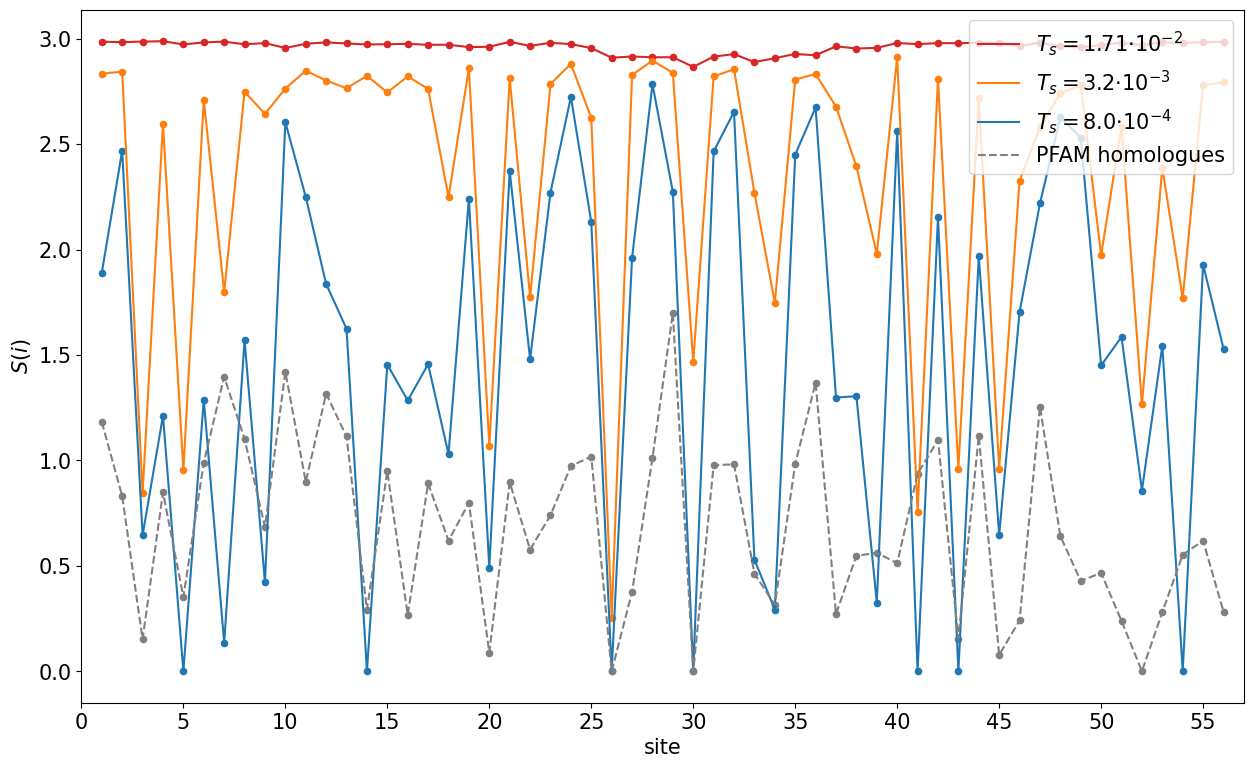

In [38]:
plotted_T = [
    0.0171,
    0.0032,
    0.0008
]
labels = [
    r'1.71$\cdot$10$^{-2}$',
    r'3.2$\cdot$10$^{-3}$',
    r'8.0$\cdot$10$^{-4}$'
]
colors = [
    '#d62728',
    '#ff7f0e',
    '#1f77b4'
]

sites = np.arange(len(alignement_site_entropy)) + 1
max_entropy = np.log(len(residues))
important_sites = np.where(mask == True)[0] + 1
xlims = [0, sites.max() + 1]

plt.rcParams.update({'font.size': 15})
fig = plt.figure(figsize = (15, 9))
ax = plt.subplot(1, 1, 1)

for T, label, color in zip(plotted_T, labels, colors):
    ax.plot(sites, sims_site_entropies[str(T)], color = color, label = r'$T_s = $' + label)
    ax.scatter(sites, sims_site_entropies[str(T)], color = color, s = 20)
    
ax.plot(sites, alignement_site_entropy, color = 'grey', linestyle = '--', label = 'PFAM homologues')
ax.scatter(sites, alignement_site_entropy, color = 'grey', s = 20)

#ax.plot(xlims, [0.] * len(xlims), linestyle = '--', label = 'fixed site')
#ax.plot(xlims, [max_entropy] * len(xlims), linestyle = '--', label = 'casual mutations')
#ax.scatter(important_sites, [0] * len(important_sites), s = 30, color = 'black', label = 'important sites')

xticks = np.arange(13) * 5
ax.set_xticks(xticks)
ax.set_xticklabels([format(xtick, ".0f") for xtick in xticks])
ax.set_xlim(xlims)
ax.set_xlabel('site')
ax.set_ylabel(r'$S(i)$')
#ax.set_title('Protein 1PGB experimental and simulated site entropies')
ax.legend(loc = 'upper right')
#ax.grid()

plt.savefig(f'plots/site_entropies.png', bbox_inches='tight');

In [43]:
from scipy.stats import pearsonr

T_list = []
for d in dirlist:
    T = float(d.split('_')[2][1:])
    T_list.append(T)
T_list = np.array(T_list)[::-1]

corrs = np.zeros(len(T_list))
for iT, T in enumerate(T_list):
    corrs[iT], _ = pearsonr(sims_site_entropies[str(T)], alignement_site_entropy)

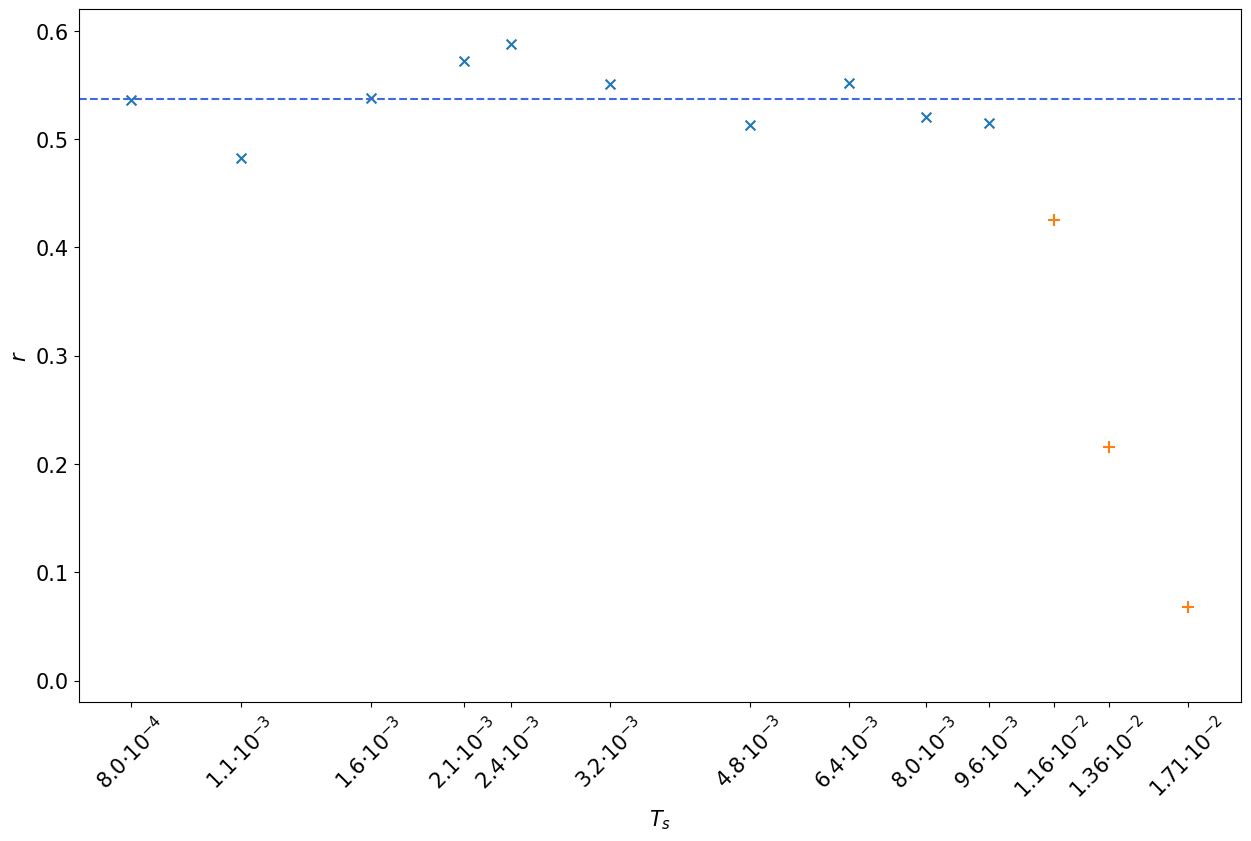

In [44]:
mask = T_list <= 0.0096
high_corrs = corrs[mask]
low_corrs = corrs[~mask]

labels = [r'8.0$\cdot$10$^{-4}$', r'1.1$\cdot$10$^{-3}$', r'1.6$\cdot$10$^{-3}$', r'2.1$\cdot$10$^{-3}$', r'2.4$\cdot$10$^{-3}$', 
          r'3.2$\cdot$10$^{-3}$', r'4.8$\cdot$10$^{-3}$', r'6.4$\cdot$10$^{-3}$', r'8.0$\cdot$10$^{-3}$', r'9.6$\cdot$10$^{-3}$', 
          r'1.16$\cdot$10$^{-2}$', r'1.36$\cdot$10$^{-2}$', r'1.71$\cdot$10$^{-2}$']

fig = plt.figure(figsize = (15, 9))
ax = plt.subplot(1, 1, 1)

ax.scatter(T_list[mask], high_corrs, color = '#1f77b4', marker = 'x', s = 50)
ax.axhline(high_corrs.mean(), linestyle = '--', color = 'royalblue')
ax.scatter(T_list[~mask], low_corrs, color = '#ff7f0e', marker = '+', s = 80)

ax.set_xscale('log')
ax.set_xticks(T_list)
ax.set_xticklabels(labels, rotation = 45)
ax.tick_params(axis = 'x', which = 'minor', bottom = False)
ax.set_xlabel(r'$T_s$')
ax.set_ylabel(r'$r$')
ax.set_ylim([-0.02, 0.62])

plt.savefig(f'plots/supp_mat/site_entropies_correlation.png', bbox_inches='tight');

In [49]:
print('Mean correlation for below-transition Ts:', format(high_corrs.mean(), ".3f"))

Mean correlation for below-transition Ts: 0.537


### Distances distribution, Hamming

#### Binomial model

In [50]:
def binomial_factor(n, k):
    n_fact = factorial(n)
    k_fact = factorial(k)
    nk_fact = factorial(n - k)
    return n_fact / (k_fact * nk_fact)

N = 56
def binomial(Q, Nv, Naa):
    Nf = N - Nv
    if Q < Nf:
        return 0
    else:
        p = 1./Naa
        binom_coeff = binomial_factor(Nv, Q - Nf)
        pdq = binom_coeff * p**(Q - Nf) * (1 - p)**(N - Q)
        return pdq
    
def get_best_parameters(sim_Q, sim_pdq):
    Nv_arr = np.arange(N) + 1
    Naa_arr = np.arange(20 - 1) + 2
    
    parameters = []
    err = np.zeros((len(Nv_arr), len(Naa_arr)))
    for iNv, Nv in enumerate(Nv_arr):
        for iNaa, Naa in enumerate(Naa_arr):
            pdq = np.array([binomial(Q, Nv, Naa) for Q in sim_Q])
            parameters.append((Nv, Naa))
            err[iNv, iNaa] = np.sqrt(np.sum((sim_pdq - pdq)**2.))
    min_idx = np.argmin(err)
    return parameters[min_idx]

In [51]:
tuples = [
    (0.0171, 0.0),
    (0.0064, 0.0),
    (0.0032, 0.0),
    (0.0016, 0.0),
    (0.0008, 0.0),
]

labels = [
    r'1.71$\cdot$10$^{-2}$',
    r'6.4$\cdot$10$^{-3}$',
    r'3.2$\cdot$10$^{-3}$',
    r'1.6$\cdot$10$^{-3}$',
    r'8.0$\cdot$10$^{-4}$'
]

colors = [
    '#d62728',
    '#9467bd',
    '#ff7f0e',
    '#2ca02c',
    '#1f77b4',
]

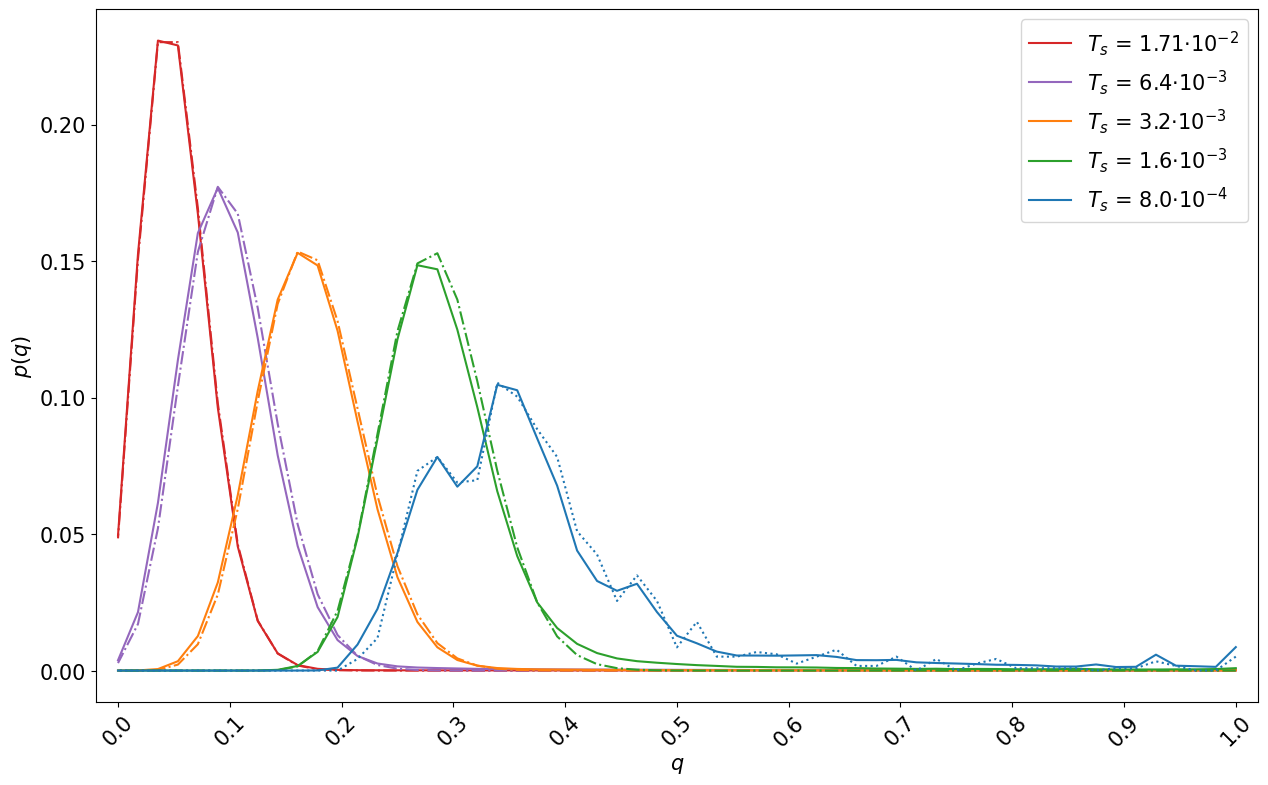

In [53]:
fig = plt.figure(figsize = (15, 9))
ax = plt.subplot(1, 1, 1)

parameters = {}
for itupl, (tupl, label, color) in enumerate(zip(tuples, labels, colors)):
    (T, gamma) = tupl
    df = pd.read_csv(f'process/hole_search/results/SM_1PGB_T{T}_g{gamma}/simple_pdf_Hamm_p1.0_s1.csv')
    df = df.drop(columns = ['Unnamed: 0'])
    ax.plot(df['q'], df['pdf'], color = color, label = r'$T_s$ = ' + label)
    
    sim_Q, sim_pdq = np.arange(len(df['q']))[::-1], df['pdf']
    parameters[str(T)] = get_best_parameters(sim_Q, sim_pdq)
    
    if T == 0.0008:
        step = 10_000
        df = pd.read_csv(f'process/hole_search/results/SM_1PGB_T{T}_g{gamma}/simple_pdf_Hamm_p1.0_s{step}.csv')
        df = df.drop(columns = ['Unnamed: 0'])
        ax.plot(df['q'], df['pdf'], color = color, linestyle = 'dotted')
        
    else:
        Nv, Naa = parameters[str(T)]
        best_pdq = np.array([binomial(Q, Nv, Naa) for Q in sim_Q])
        ax.plot(df['q'], best_pdq, color = color, linestyle = 'dashdot')

xticks = np.linspace(0, df['q'].max(), 11)
ax.set_xticks(xticks)
ax.set_xticklabels([format(xtick, ".1f") for xtick in xticks], rotation = 45)
ax.set_xlim([-0.02, 1.02])
ax.set_xlabel(r'$q$')
ax.set_ylabel(r'$p(q)$')
ax.legend()

plt.savefig(f'plots/pdq_simple.png', bbox_inches='tight')

#### Weighted distance

In [55]:
tuples = [
    (0.0171, 0.0),
    (0.0032, 0.0),
    (0.0016, 0.0),
    (0.0008, 0.0),
]

labels = [
    r'1.71$\cdot$10$^{-2}$',
    r'3.2$\cdot$10$^{-3}$',
    r'1.6$\cdot$10$^{-3}$',
    r'8.0$\cdot$10$^{-4}$'
]

colors = [
    '#d62728',
    '#ff7f0e',
    '#2ca02c',
    '#1f77b4',
]

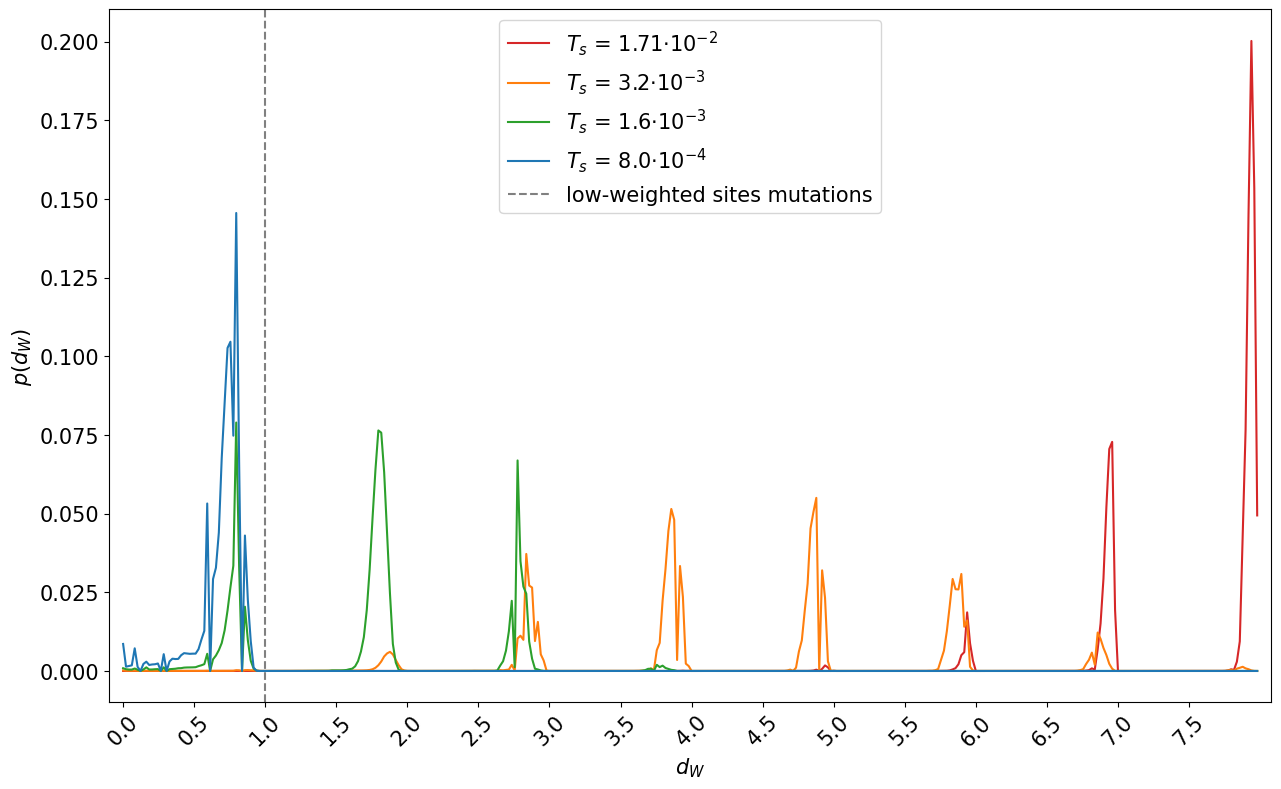

In [56]:
fig = plt.figure(figsize = (15, 9))
ax = plt.subplot(1, 1, 1)

for tupl, label, color in zip(tuples, labels, colors):
    (T, gamma) = tupl
    df = pd.read_csv(f'process/hole_search/results/SM_1PGB_T{T}_g{gamma}/weighted_pdf_Hamm_p0.0_s1.csv')
    df = df.drop(columns = ['Unnamed: 0'])
    
    ax.plot(df['distances'], df['pdf'], color = color, label = r'$T_s$ = ' + label)
ax.axvline(x = 1.0, linestyle = '--', color = 'grey', label = 'low-weighted sites mutations')    

xticks = np.arange(df['distances'].max() / 0.5) * 0.5
ax.set_xticks(xticks)
ax.set_xticklabels([format(xtick, ".1f") for xtick in xticks], rotation = 45)
ax.set_xlim([-0.1, df['distances'].max() + 0.1])
ax.set_xlabel(r'$d_{W}$')
ax.set_ylabel(r'$p(d_{W})$')
ax.legend()

plt.savefig(f'plots/pdd_weighted.png', bbox_inches='tight');

### Simple fixed-random model 

#### Binomial model

In [57]:
def binomial_factor(n, k):
    n_fact = factorial(n)
    k_fact = factorial(k)
    nk_fact = factorial(n - k)
    return n_fact / (k_fact * nk_fact)

N = 56
def binomial(Q, Nv, Naa):
    Nf = N - Nv
    if Q < Nf:
        return 0
    else:
        p = 1. / Naa
        binom_coeff = binomial_factor(Nv, Q - Nf)
        pdq = binom_coeff * p**(Q - Nf) * (1 - p)**(N - Q)
        return pdq
    
def get_best_parameters(sim_Q, sim_pdq):
    Nv_arr = np.arange(N) + 1
    Naa_arr = np.arange(20 - 1) + 2
    
    parameters = []
    err = np.zeros((len(Nv_arr), len(Naa_arr)))
    for iNv, Nv in enumerate(Nv_arr):
        for iNaa, Naa in enumerate(Naa_arr):
            pdq = np.array([binomial(Q, Nv, Naa) for Q in sim_Q])
            parameters.append((Nv, Naa))
            err[iNv, iNaa] = np.sqrt(np.sum((sim_pdq - pdq)**2.))
    min_idx = np.argmin(err)
    return parameters[min_idx]

In [58]:
tuples = [
    (0.0008, 0.0),
    (0.0016, 0.0),
    (0.0032, 0.0),
    (0.0064, 0.0),
    (0.0171, 0.0)
]

In [59]:
bin_parameters = {}
for itupl, tupl in enumerate(tuples):
    (T, gamma) = tupl
    df = pd.read_csv(f'process/hole_search/results/SM_1PGB_T{T}_g{gamma}/simple_pdf_Hamm_p1.0_s1.csv')
    df = df.drop(columns = ['Unnamed: 0'])
    
    sim_Q, sim_pdq = np.arange(len(df['q']))[::-1], df['pdf']
    bin_parameters[str(T)] = get_best_parameters(sim_Q, sim_pdq)

In [60]:
bin_parameters

{'0.0008': (55, 3),
 '0.0016': (48, 6),
 '0.0032': (54, 7),
 '0.0064': (56, 10),
 '0.0171': (56, 19)}

In [61]:
dirlist = [f'SM_1PGB_T{T}_g0.0' for T in bin_parameters]
dirlist

['SM_1PGB_T0.0008_g0.0',
 'SM_1PGB_T0.0016_g0.0',
 'SM_1PGB_T0.0032_g0.0',
 'SM_1PGB_T0.0064_g0.0',
 'SM_1PGB_T0.0171_g0.0']

---
... KS test

In [33]:
def calculate_Hamming_distances(sequences, ref_sequence, mask):
    sequences = np.array([list(sequence) for sequence in sequences])
    masked_sequences = np.array([sequence[mask] for sequence in sequences])
    masked_ref_sequence = np.array(list(ref_sequence))[mask]
    distances = np.array([len(np.where(sequence != masked_ref_sequence)[0]) for sequence in masked_sequences])
    return distances

def calculate_autocorrelation(x, max_t, max_shift):
    autocorrelation = []
    for t in range(max_shift):
        numerator = np.mean(x[:(max_t-t)]*x[t:max_t]) - np.mean(x[:(max_t-t)])*np.mean(x[t:max_t])
        denominator = np.var(x[:max_t])
        autocorrelation.append(numerator/denominator)
    return np.array(autocorrelation)

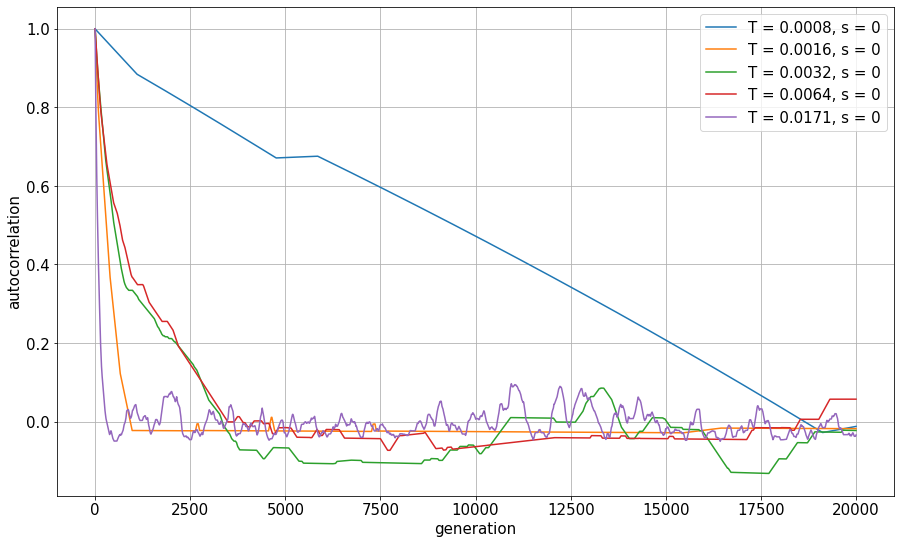

In [45]:
max_t, max_shift = 100_000, 20_000

fig = plt.figure(figsize = (15, 9))
ax = plt.subplot(1, 1, 1)
for d in dirlist:
    T = d.split('_')[-2][1:]
    block_file = [f for f in listdir(f'results/{d}') if isfile(f'results/{d}/{f}') and ('block_data' in f)]
    block_file = block_file[0]
    block_data = pd.read_csv(f'results/{d}/{block_file}')
    seed_ds = [subd for subd in listdir(f'results/{d}') if isdir(f'results/{d}/{subd}')]
    discarded_mutations = int(block_data.loc[0, 'discarded_mutations'] / len(seed_ds))
    
    #for seed_d in seed_ds:
    seed_d = 's0'
    actual_d = f'results/{d}/{seed_d}'
    seed_muts = load_muts(actual_d, return_eq = False, return_pars = False)
    seed_mutants = seed_muts[discarded_mutations:, 1]
        
    ref_mutant = seed_mutants[0]
    mask = np.ones(len(ref_mutant), dtype = int)
    seed_distances = calculate_Hamming_distances(seed_mutants, ref_mutant, mask)
    autocorrelation = calculate_autocorrelation(seed_distances, max_t, max_shift)
    
    ax.plot(np.arange(max_shift) + 1, autocorrelation, label = f'T = {T}, s = {seed_d[1:]}')
    
ax.set_xlabel('generation')
ax.set_ylabel('autocorrelation')
ax.legend()
ax.grid();

In [20]:
def cdf(sample, x, sort = False):
    if sort:
        sample.sort()
    cdf = sum(sample <= x)
    cdf = cdf / len(sample)
    return cdf


def ks_2samp(sample1, sample2, bins, sort_sample1 = False, sort_sample2 = False):
    if sort_sample1: sample1.sort()
    if sort_sample2: sample2.sort()
    
    D_ks = []
    for x in bins:
        cdf_sample1 = cdf(sample = sample1, x  = x)
        cdf_sample2 = cdf(sample = sample2, x  = x)
        D_ks.append(abs(cdf_sample1 - cdf_sample2))
    ks_stat = max(D_ks)
    
    m, n = float(len(sample1)), float(len(sample2))
    en = m * n / (m + n)
    p_value = stats.kstwo.sf(ks_stat, np.round(en))
    return {"ks_stat": ks_stat, "p_value" : p_value}

In [58]:
steps = [
    15_000,
    800,
    800,
    800,
    800
]

print('Performing the two-sample Kolmogorov-Smirnov test...')
bins = np.arange(57)[::-1]
ks_test = {}
for d, step in zip(dirlist, steps):    
    # Generating simulated data
    T = d.split('_')[-2][1:]
    block_file = [f for f in listdir(f'results/{d}') if isfile(f'results/{d}/{f}') and ('block_data' in f)]
    block_file = block_file[0]
    block_data = pd.read_csv(f'results/{d}/{block_file}')
    seed_ds = [subd for subd in listdir(f'results/{d}') if isdir(f'results/{d}/{subd}')]
    discarded_mutations = int(block_data.loc[0, 'discarded_mutations'] / len(seed_ds))
    total_data = 0
    for seed_d in seed_ds:
        actual_d = f'results/{d}/{seed_d}'
        seed_muts = load_muts(actual_d, return_eq = False, return_pars = False)
        total_data += len(seed_muts[discarded_mutations::step])
    
    df = pd.read_csv(f'process/hole_search/results/SM_1PGB_T{T}_g0.0/simple_pdf_Hamm_p1.0_s1.csv')
    df = df.drop(columns = ['Unnamed: 0'])
    Q = []
    for Q_value, p_q in zip(bins, df['pdf']):
        Q = Q + [Q_value] * int(p_q * total_data)
    Q = np.array(Q)
    
    # Generate binomial-distributed data
    n, p = bin_parameters[T][0], 1./bin_parameters[T][1]
    generated_Q = binom.rvs(n, p, size = total_data) + (N - n)
    
    #fig = plt.figure(figsize = (9, 6))
    #plt.hist(Q, bins = np.arange(57), alpha = 0.5, density = True, label = 'true Q', cumulative=True)
    #plt.hist(generated_Q, bins = np.arange(57), alpha = 0.5, density = True, label = 'gen Q', cumulative=True)
    #plt.title(T)
    #plt.legend()
    
    # KS test
    ks_test[T] = ks_2samp(Q, generated_Q, bins, sort_sample1 = False, sort_sample2 = True)
    print(f'T = {T}\ttotal data = {total_data}\tstats = {ks_test[T]["ks_stat"]}\tp_value = {ks_test[T]["p_value"]}')

Performing the two-sample Kolmogorov-Smirnov test...
T = 0.0008	total data = 33	stats = 0.18181818181818177	p_value = 0.7190381285140863
T = 0.0016	total data = 624	stats = 0.02563302615299279	p_value = 0.9849206458406473
T = 0.0032	total data = 1458	stats = 0.039538896784491906	p_value = 0.20166366553143378
T = 0.0064	total data = 320	stats = 0.03307629870129869	p_value = 0.9932838100478094
T = 0.0171	total data = 288	stats = 0.03125	p_value = 0.9984077874585334


---
... $\chi^{2}$ test

In [60]:
def binned_points_number(sample, xi, xf, sort = False):
    if sort:
        sample.sort()
    xi, xf = np.min([xi, xf]), np.max([xi, xf])
    binned_points = [el for el in sample if (el > xi) and (el <= xf)]
    return len(binned_points)


def chi2_2samp(sample1, sample2, bins, sort_sample1 = False, sort_sample2 = False):
    if sort_sample1: sample1.sort()
    if sort_sample2: sample2.sort()
    
    observed, expected = [], []
    for (xi, xf) in zip(bins[:-1], bins[1:]):
        observed.append(binned_points_number(sample1, xi, xf))
        expected.append(binned_points_number(sample2, xi, xf))
    observed = np.array(observed)
    expected = np.array(expected)
    
    mask = expected > 100
    observed = observed[mask]
    expected = expected[mask]
    
    chi2_stat, p_value = chisquare(observed, expected)
    return {"chi2_stat": chi2_stat, "p_value" : p_value}

In [62]:
print('Performing the chi-squared test...')
bins = np.arange(58)[::-1] - 0.5
chi2_test = {}
for d, T in zip(dirlist, bin_parameters):    
    # Generating simulated data
    block_file = [f for f in listdir(f'results/{d}') if isfile(f'results/{d}/{f}') and ('block_data' in f)]
    block_file = block_file[0]
    block_data = pd.read_csv(f'results/{d}/{block_file}')
    seed_ds = [subd for subd in listdir(f'results/{d}') if isdir(f'results/{d}/{subd}')]
    discarded_mutations = int(block_data.loc[0, 'discarded_mutations'] / len(seed_ds))
    total_data = 0
    for seed_d in seed_ds:
        actual_d = f'results/{d}/{seed_d}'
        seed_muts = load_muts(actual_d, return_eq = False, return_pars = False)
        total_data += len(seed_muts[discarded_mutations:])
        
    df = pd.read_csv(f'process/hole_search/results/SM_1PGB_T{T}_g0.0/simple_pdf_Hamm_p1.0_s1.csv')
    df = df.drop(columns = ['Unnamed: 0'])
    Q = []
    for Q_value, p_q in zip(bins, df['pdf']):
        Q = Q + [Q_value] * int(p_q * total_data)
    Q = np.array(Q)
    
    # Generate binomial-distributed data
    n, p = bin_parameters[T][0], 1./bin_parameters[T][1]
    generated_Q = binom.rvs(n, p, size = 100_000) + (N - n)
    
    #fig = plt.figure(figsize = (9, 6))
    #plt.hist(Q, bins = np.arange(57), alpha = 0.5, density = True, label = 'true Q', cumulative=True)
    #plt.hist(generated_Q, bins = np.arange(57), alpha = 0.5, density = True, label = 'gen Q', cumulative=True)
    #plt.title(T)
    #plt.legend()
    
    # chi-squared test
    chi2_test[T] = chi2_2samp(Q, generated_Q, bins, sort_sample1 = False, sort_sample2 = True)
    
    print(f'T = {T}\tstats = {chi2_test[T]["chi2_stat"]}\tp_value = {chi2_test[T]["p_value"]}')
    #print(f'T = {T}\tpvalue = {format(pvalues[T], ".10f")}\tNv = {bin_parameters[T][0]}\tNaa = {bin_parameters[T][1]}')

Performing the chi-squared test...
T = 0.0008	stats = 1440876.4592573822	p_value = 0.0
T = 0.0016	stats = 1483534.5677207392	p_value = 0.0
T = 0.0032	stats = 11271452.667290853	p_value = 0.0
T = 0.0064	stats = 238483.66249732024	p_value = 0.0
T = 0.0171	stats = 167677.47472599574	p_value = 0.0


#### Gaussian model

In [251]:
num = 57
def gaussian(x, mu, var):
    f = lambda x, mu, var : np.exp(-(x - mu)**2./(2. * var))
    numerator = f(x, mu, var)
    norm = np.sum( [f(x, mu, var) for x in np.linspace(0., 1., num)] )
    return numerator / norm

def complete_mufunc(N, Naa):  ## for q variable
    x = N/56.
    y = 1./Naa
    return 1. - x + x * y

def complete_varfunc(N, Naa):
    x = N/56.
    y = 1./Naa
    return x ** 2. * y * (1. - y) / N

def get_N_best(mu_q, var_q):
    num = 56. * (1. - mu_q)**2.
    den = 1. - mu_q - 56. * var_q
    N_best = int(num / den + 0.5) if int(num / den + 0.5) <= 56 else 56
    return N_best

def get_Naa_best(mu_q, var_q):
    num = 1. - mu_q
    den = 56. * var_q
    Naa_best = int(num / den + 0.5) if int(num / den + 0.5) <= 20 else 20
    return Naa_best

In [252]:
tuples = [
    (0.0008, 0.0),
    (0.0016, 0.0),
    (0.0032, 0.0),
    (0.0064, 0.0),
    (0.0171, 0.0)
]

In [253]:
gauss_parameters = {}
for itupl, tupl in enumerate(tuples):
    (T, gamma) = tupl
    df = pd.read_csv(f'process/hole_search/results/SM_1PGB_T{T}_g{gamma}/simple_pdf_Hamm_p1.0_s1.csv')
    df = df.drop(columns = ['Unnamed: 0'])
    popt, pcov = curve_fit(gaussian, df['q'], df['pdf'], p0 = [0.3, 19./(20.**2. * 56.)])
    gauss_parameters[str(T)] = popt

/home/alessandroz/Desktop/myenv/lib64/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/alessandroz/Desktop/myenv/lib64/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


In [254]:
appo = []
for T in bin_parameters:
    # binomial
    bin_Nv, bin_Naa = bin_parameters[T]
    # gaussian
    mu, var = gauss_parameters[T]
    gauss_Nv, gauss_Naa = get_N_best(mu, var), get_Naa_best(mu, var)
    
    appo.append([float(T), bin_Nv, bin_Naa, gauss_Nv, gauss_Naa])
df_best = pd.DataFrame(appo, columns = ['T', 'Nv, bin', 'Naa, bin', 'Nv, gauss', 'Naa, gauss'])
df_best

,T,"Nv, bin","Naa, bin","Nv, gauss","Naa, gauss"
0,0.0008,55,3,56,2
1,0.0016,48,6,49,6
2,0.0032,54,7,54,7
3,0.0064,56,10,56,10
4,0.0171,56,19,56,18


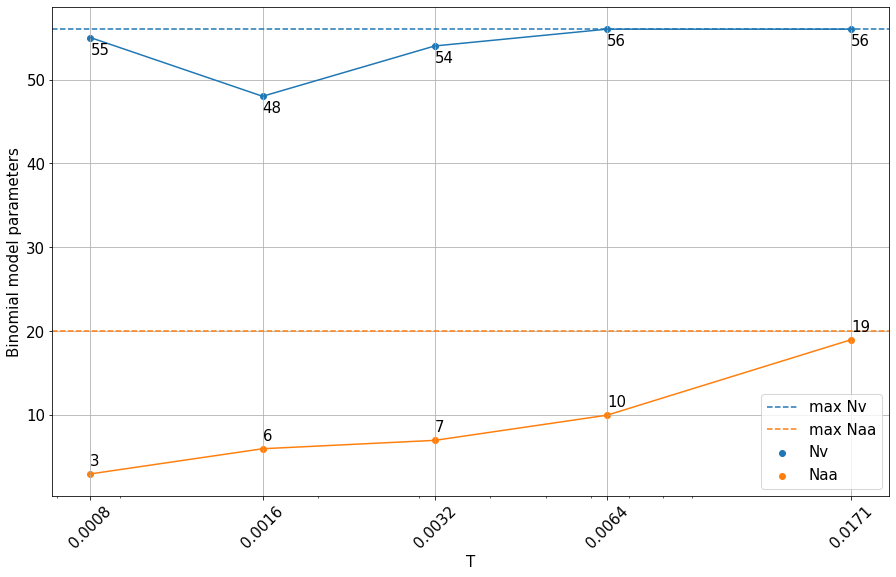

In [255]:
model = 'bin'

plt.rcParams.update({'font.size': 15})
fig = plt.figure(figsize = (15, 9))
ax = plt.subplot(1, 1, 1)

# Nv
color = '#1f77b4' # blue
ax.plot(df_best['T'], df_best[f'Nv, {model}'], color = color)
ax.scatter(df_best['T'], df_best[f'Nv, {model}'], color = color, label = 'Nv')
for T, N_best in zip(df_best['T'], df_best[f'Nv, {model}']):
    ax.annotate(f'{N_best}', xy=(T, N_best), xytext=(T, N_best - 2))
ax.axhline(y = 56, linestyle = '--', color = color, label = 'max Nv')

# Naa_best
color = '#ff7f0e' # orange
ax.plot(df_best['T'], df_best[f'Naa, {model}'], color = color)
ax.scatter(df_best['T'], df_best[f'Naa, {model}'], color = color, label = 'Naa')
for T, Naa_best in zip(df_best['T'], df_best[f'Naa, {model}']):
    ax.annotate(f'{Naa_best}', xy=(T, Naa_best), xytext=(T, Naa_best + 1))
ax.axhline(y = 20, linestyle = '--', color = color, label = 'max Naa')

ax.set_xscale('log')
xticks = df_best['T']
ax.set_xticks(xticks)
ax.set_xticklabels([format(xtick, ".4f") for xtick in xticks], rotation = 45)
ax.set_xlabel('T')
if model == 'bin': ax.set_ylabel('Binomial model parameters')
elif model == 'gauss': ax.set_ylabel('Gaussian model parameters')
ax.legend()
ax.grid()

#plt.savefig(f'plots/{model}_parameters.png', bbox_inches='tight');

---
## Important sites - number of combinations and correlations

In [ ]:
site_weights = np.load('run/inputs/site_weights.npy')
mask = site_weights == 1.

#new_site_weights = site_weights.copy()
#new_site_weights[13] = 1./56.
#new_site_weights[53] = 1./56.
#new_mask = new_site_weights == 1.

In [ ]:
dirlist = T_dirlist
T, gamma = 0.0032, 0.0
d = [d for d in dirlist if (str(T) in d) and (str(gamma) in d)][0]

block_file = [f for f in listdir(f'results/{d}') if isfile(f'results/{d}/{f}') and ('block_data' in f)]
assert len(block_file) == 1, 'Block data file not found'
block_file = block_file[0]
block_data = pd.read_csv(f'results/{d}/{block_file}')

In [ ]:
fig = plt.figure(figsize = (12, 9))
ax = plt.subplot(1, 1, 1)

nblocks = 100
seed_ds = [subd for subd in listdir(f'results/{d}') if isdir(f'results/{d}/{subd}')]
discarded_mutations = int(block_data.loc[0, 'discarded_mutations'] / len(seed_ds))
for iseed, seed_d in enumerate(seed_ds):
    actual_d = f'results/{d}/{seed_d}'
    seed_muts = load_muts(actual_d, return_eq = False, return_pars = False)
    seed_mutants = seed_muts[:, 1].astype(str)
    mutants = seed_mutants[discarded_mutations:].copy()
    seed = int(seed_d[1:])

    block_length = int(len(mutants) / nblocks)
    splitted_mutants = np.array([list(mutant) for mutant in mutants])
    masked_sites = np.array([''.join(mutant[mask]) for mutant in splitted_mutants])
    block_sites = np.array([0] + [len(np.unique(masked_sites[:block_length * (iblock + 1)])) for iblock in range(nblocks)])
    blocks_lengths = np.array([0] + [block_length * (iblock + 1) for iblock in range(nblocks)])
    ax.plot(blocks_lengths, block_sites, label = f'seed = {seed}')
    ax.scatter(blocks_lengths, block_sites)

#ax.legend()
ax.grid()
ax.set_xlabel('generations')
ax.set_ylabel('unique combinations')
plt.savefig(f'plots/supp_mat/unique_combs.png', bbox_inches='tight');

In [ ]:
seed_ds = [subd for subd in listdir(f'results/{d}') if isdir(f'results/{d}/{subd}')]
discarded_mutations = int(block_data.loc[0, 'discarded_mutations'] / len(seed_ds))
energies, mutants = np.array([]), np.array([])
for iseed, seed_d in enumerate(seed_ds):
    actual_d = f'results/{d}/{seed_d}'
    seed_muts = load_muts(actual_d, return_eq = False, return_pars = False)
    seed_mutants = seed_muts[:, 1].astype(str)
    seed_data = load_data(actual_d, return_eq = False)
    seed_energies = seed_data[:, 1]
    if iseed == 0: 
        mutants = seed_mutants[discarded_mutations:].copy()
        energies = seed_energies[discarded_mutations:].copy()
    else:
        mutants = np.append(mutants, seed_mutants[discarded_mutations:], axis = 0)
        energies = np.append(energies, seed_energies[discarded_mutations:], axis = 0)

In [ ]:
residues = orig_residues
def get_correlation(combinations, step = 1_000):
    mutations = combinations.T
    indexes = np.arange(len(mutations))
    
    # prepare combinations for row-col and alpha-beta
    ij_combs = []
    for i in indexes:
        for j in indexes:
            if i <= j: ij_combs.append((i, j))
    ij_combs = np.array(ij_combs)
            
    alpha_beta_matrix = []
    for alpha in residues:
        for beta in residues:
            alpha_beta_matrix.append((alpha, beta))
    alpha_beta_matrix = np.array(alpha_beta_matrix)
    
    # correlation matrix
    C = np.zeros((len(indexes), len(indexes)))
    for (i, j) in ij_combs:
        # same site
        if i == j:
            i_mutations = mutations[i]
            i_frequencies = np.array([(i_mutations == residue).astype(int).mean() for residue in residues])
            i_frequencies[i_frequencies == 0.] = 1.
            C_ij = -np.sum(i_frequencies * np.log(i_frequencies))
        
        # different site
        else:
            i_mutations, j_mutations = mutations[i], mutations[j]
            C_ij = 0.
            for (alpha, beta) in alpha_beta_matrix:
                pi_alpha = (i_mutations == alpha).astype(int).mean()
                pj_beta = (j_mutations == beta).astype(int).mean()
                p_mixed = ((i_mutations == alpha).astype(int) * (j_mutations == beta).astype(int)).mean()
                if pi_alpha != 0 and pj_beta != 0 and p_mixed != 0.:
                    C_ij += p_mixed * np.log(p_mixed / (pi_alpha * pj_beta))
        
        C[i, j] = C_ij
        C[j, i] = C_ij
    return C

In [ ]:
splitted_mutants = np.array([list(mutant) for mutant in mutants])
combinations = np.array([mutant[mask] for mutant in splitted_mutants])
corr_matrix = get_correlation(combinations)

In [ ]:
ticks = (np.arange(56) + 1)[mask]

fig = plt.figure(figsize = (12, 10))
ax = sns.heatmap(corr_matrix, vmax = 1., annot = True)
ax.set_xticklabels(ticks)
ax.set_yticklabels(ticks)
plt.savefig(f'plots/supp_mat/correlations.png', bbox_inches='tight');